# Physics-informed neural network (PINN) demo


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os

## Initial setup

First, we define a few helper functions.

In [4]:
E = 2 * 1e11
# print(E)
c = 10000
A = 0.001963495220625
L = 1
x = np.linspace(0,1,20)
# print(x)

u = (c / (6 * A * E)) * (3 * L**(2) *(x) - (x**(3)))
print(u)

[0.00000000e+00 6.69507372e-07 1.33530213e-06 1.99367168e-06
 2.64090339e-06 3.27328466e-06 3.88710287e-06 4.47864543e-06
 5.04419972e-06 5.58005312e-06 6.08249304e-06 6.54780685e-06
 6.97228195e-06 7.35220572e-06 7.68386557e-06 7.96354887e-06
 8.18754302e-06 8.35213540e-06 8.45361342e-06 8.48826444e-06]


In [5]:
def exact_solution(c,L,A,E,k,x):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    u = (c / (6 * A * E)) * (3 * L**(2) *(x) - (x**(3)))
    return (u)

class FCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

tensor([[0.]], requires_grad=True)


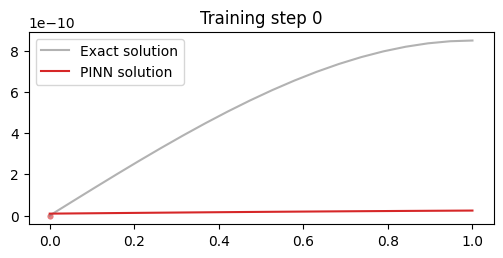

Epoch [1/1000], Loss: 59.9200
BC1 LOSS 0.013923680409789085
BC2 LOSS 0.00025921547785401344
PDE LOSS 85.58007049560547


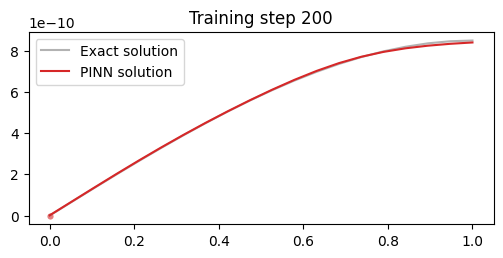

Epoch [201/1000], Loss: 0.4460
BC1 LOSS 0.00013207015581429005
BC2 LOSS 1.1165236234664917
PDE LOSS 0.15847459435462952


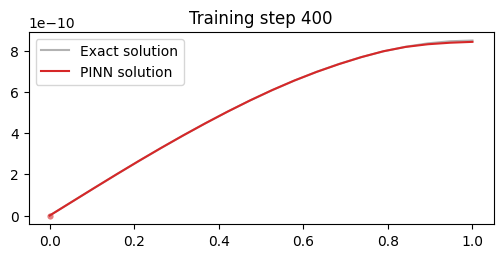

Epoch [401/1000], Loss: 0.1478
BC1 LOSS 1.2313603292568587e-07
BC2 LOSS 0.3675028383731842
PDE LOSS 0.05358855798840523


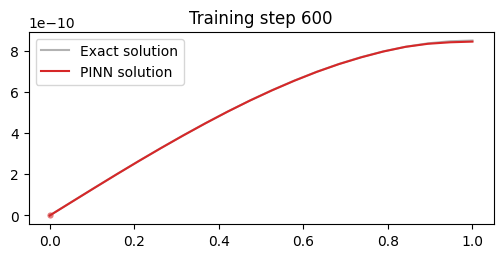

Epoch [601/1000], Loss: 0.0686
BC1 LOSS 8.729146429686807e-06
BC2 LOSS 0.1629451960325241
PDE LOSS 0.02808292955160141


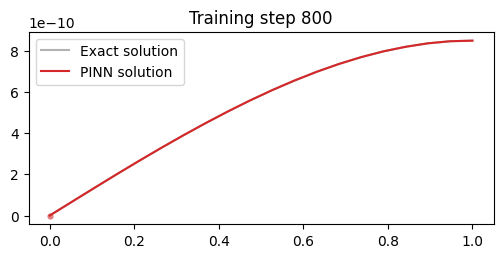

Epoch [801/1000], Loss: 0.0019
BC1 LOSS 2.1521456616824253e-08
BC2 LOSS 0.000673102040309459
PDE LOSS 0.0023714902345091105


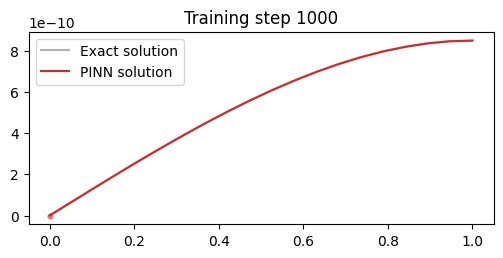

Epoch [1001/1000], Loss: 0.0009
BC1 LOSS 8.37099278783171e-09
BC2 LOSS 0.00019135022012051195
PDE LOSS 0.0012098272563889623


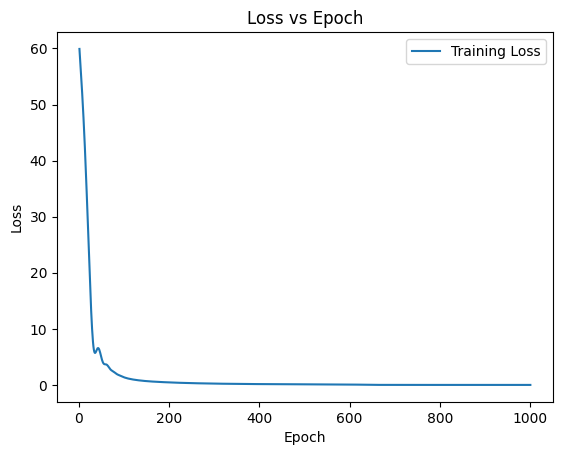

In [6]:
# define a neural network to train
pinn = FCN(1,1,64,3)

# define boundary points, for the boundary loss
x_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)# (1, 1)
print(x_boundary)
x_boundary2 = torch.tensor(1.).view(-1, 1).requires_grad_(True)  # (1, 1) at x = 1


# define training points over the entire domain, for the physics loss
x_physics = torch.linspace(0, 1, 500).view(-1,1).requires_grad_(True)# (20, 1)
# print(x_physics)


E = 2 * 1e11
c = 1
k = 1e10
A = 0.001963495220625
L = 1
# x_test = torch.linspace(0,1,200).view(-1,1) #(200, 1)
x_test = torch.linspace(0,1,20).view(-1,1) #(200, 1)

u_exact = exact_solution(c,L,A,E,k,x_test)
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-3)
num_epochs = 1000
losses = []
for i in range(num_epochs+1):
    optimiser.zero_grad()

    # compute each term of the PINN loss function above
    # using the following hyperparameters
    lambda1, lambda2 = 0.3, 0.7

    # compute boundary loss
    u = pinn(x_boundary)# (1, 1)
    # loss1 = (torch.squeeze(u) - 0)**2
    loss1 = (torch.squeeze(u) - 0)**2

    u2 = pinn(x_boundary2)
    # u2 = pinn(x_boundary2)
    # dudx2 = torch.autograd.grad(u2, x_boundary2, torch.ones_like(u2), create_graph=True)[0]  # (1, 1)
    # loss2 = (torch.squeeze(dudx2))**2  # Enforce dudx = 0 at x = 1
    dudx = torch.autograd.grad(u2, x_boundary2, torch.ones_like(u), create_graph=True)[0]# (1, 1)
    loss2 = (torch.squeeze(dudx) - 0)**2

    # compute physics loss
    u = pinn(x_physics)# (20, 1)
    dudx = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]# (20, 1)
    d2udx2 = torch.autograd.grad(dudx, x_physics, torch.ones_like(dudx), create_graph=True)[0]# (20, 1)
    # loss3 = torch.mean((d2udx2 - M/(E*I))**2)
    loss3 = torch.mean((dudx - (0.5*k*c*(L**2 - x_physics**2))/(A*E))**2)
    # loss3 = torch.mean(((A*E)*dudx - (0.5*c*(L**2 - x_physics**2)))**2)
    # loss3 = torch.mean(A*E *d2udx2 + c *x_physics)
    # loss3 = torch.mean(d2udx2 + (c/(A*E)) *x_physics)

    # loss3 = torch.mean((dudx-x_physics)**2)


    # backpropagate joint loss, take optimiser step
    # loss = loss1 + lambda1 * loss2 + lambda2 * loss3
    loss = loss1 + lambda1*loss2+ lambda2 * loss3
    loss.backward()
    optimiser.step()
    losses.append(loss.item())

    # plot the result as training progresses
    if i % 200 == 0:
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = pinn(x_test).detach()
        plt.figure(figsize=(6,2.5))
        # plt.scatter(x_physics.detach()[:,0], torch.zeros_like(x_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(x_boundary.detach()[:,0], torch.zeros_like(x_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(x_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(x_test[:,0], u[:,0]/k, label="PINN solution", color="tab:red")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()
        print(f"Epoch [{i+1}/{num_epochs}], Loss: {loss.item():.4f}")
        print(f'BC1 LOSS {loss1}')
        print(f'BC2 LOSS {loss2}')
        print(f'PDE LOSS {loss3}')
    # plt.close()



plt.plot(range(1, num_epochs+2), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [7]:
print (u/k)
print(u_exact)

tensor([[-9.1150e-15],
        [ 6.6866e-11],
        [ 1.3353e-10],
        [ 1.9942e-10],
        [ 2.6412e-10],
        [ 3.2730e-10],
        [ 3.8865e-10],
        [ 4.4783e-10],
        [ 5.0443e-10],
        [ 5.5801e-10],
        [ 6.0820e-10],
        [ 6.5474e-10],
        [ 6.9723e-10],
        [ 7.3517e-10],
        [ 7.6835e-10],
        [ 7.9640e-10],
        [ 8.1856e-10],
        [ 8.3524e-10],
        [ 8.4546e-10],
        [ 8.4840e-10]])
tensor([[0.0000e+00],
        [6.6951e-11],
        [1.3353e-10],
        [1.9937e-10],
        [2.6409e-10],
        [3.2733e-10],
        [3.8871e-10],
        [4.4786e-10],
        [5.0442e-10],
        [5.5801e-10],
        [6.0825e-10],
        [6.5478e-10],
        [6.9723e-10],
        [7.3522e-10],
        [7.6839e-10],
        [7.9635e-10],
        [8.1875e-10],
        [8.3521e-10],
        [8.4536e-10],
        [8.4883e-10]])


Avg Percentage Error is: 999894351872.0


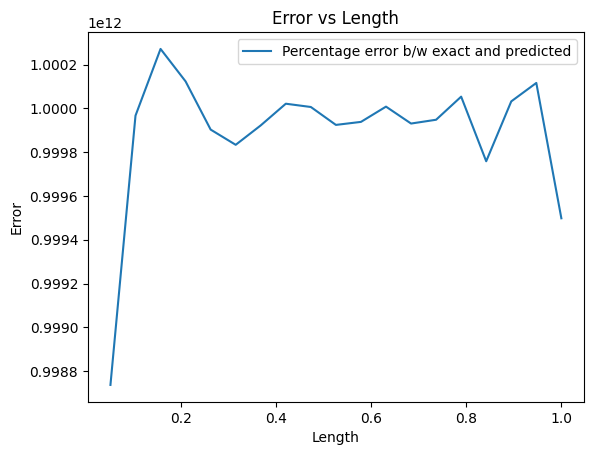

In [8]:
diff = abs(u_exact-u)/abs(0.01*u_exact)
print(f'Avg Percentage Error is: {torch.mean(diff[1:])}')
plt.plot(x_test, diff, label='Percentage error b/w exact and predicted')
plt.xlabel('Length')
plt.ylabel('Error')
plt.title('Error vs Length')
plt.legend()
plt.show()

Overall RMSE is: 5.919641971588135


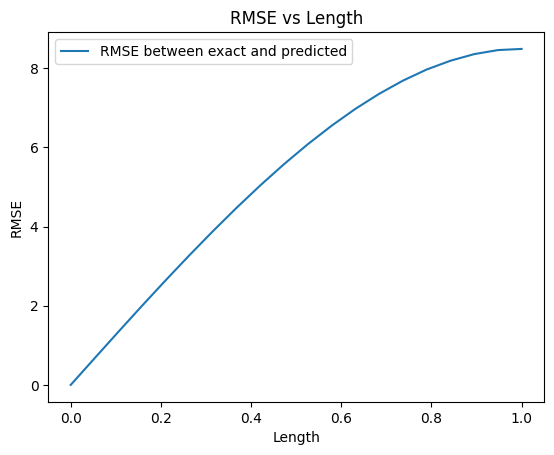

In [9]:
# Assuming u_exact and u are NumPy arrays
u_exact2 = u_exact.numpy()
u2 = u.numpy()

# Calculate RMSE at each point
rmse_per_point = np.sqrt(np.mean((u_exact2 - u2)**2, axis=1))
overall_rmse = np.sqrt(np.mean((u_exact2 - u2)**2))
print(f'Overall RMSE is: {overall_rmse}')

# Plot the RMSE at each point
plt.plot(x_test, rmse_per_point, label='RMSE between exact and predicted')
plt.xlabel('Length')
plt.ylabel('RMSE')
plt.title('RMSE vs Length')
plt.legend()
plt.show()